# Continuous Glucose Monitoring

This notebook serves as an introduction to working with the CGM data in mHealth format. It will open one file and make a few plots.

Information on this format may be found at https://github.com/openmhealth 


File organization is expected to follow this pattern:

pilot_data_root           
&emsp;wearable_blood_glucose    
&emsp;&emsp;manifest.tsv    
&emsp;&emsp;continuous_glucose_monitoring    
&emsp;&emsp;&emsp;dexcom_g6    
&emsp;&emsp;&emsp;&emsp;0001    
&emsp;&emsp;&emsp;&emsp;&emsp;0001_DEX.json     
&emsp;&emsp;&emsp;&emsp;0002    
&emsp;&emsp;&emsp;&emsp;&emsp;0002_DEX.json   
&emsp;&emsp;&emsp;&emsp;... etc.

In [927]:
import json

import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt  # to make plots
import matplotlib.dates as mdates  # to use ConciseDateFormatter

In [928]:
print(f'pd version: {pd.__version__}')  # pd 2.1.4 was used for dev

pd version: 2.2.2


## custom path -- change to match your file structure

In [929]:
pilot_data_root = "Dataset/dataset/"  # change this to your own path

# Read the manifest

In [930]:
manifest_path = pilot_data_root + "wearable_blood_glucose/manifest.tsv"
print(manifest_path)

Dataset/dataset/wearable_blood_glucose/manifest.tsv


In [931]:
dfm = pd.read_csv(manifest_path, sep='\t')
print(dfm.columns)

Index(['participant_id', 'glucose_filepath', 'glucose_level_record_count',
       'average_glucose_level_mg_dl', 'glucose_sensor_sampling_duration_days',
       'glucose_sensor_id', 'manufacturer', 'manufacturer_model_name'],
      dtype='object')


In [932]:
dfm['participant_id'].nunique()  # number of unique participants

1049

In [933]:
dfm.head()

,participant_id,glucose_filepath,glucose_level_record_count,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days,glucose_sensor_id,manufacturer,manufacturer_model_name
0,1001,wearable_blood_glucose/continuous_glucose_moni...,2856,123.304272,11,PG15103578,Dexcom,G6
1,1002,wearable_blood_glucose/continuous_glucose_moni...,2844,116.446203,11,PG15103578,Dexcom,G6
2,1003,wearable_blood_glucose/continuous_glucose_moni...,2856,208.075280,11,PG15103578,Dexcom,G6
3,1004,wearable_blood_glucose/continuous_glucose_moni...,2856,188.661064,11,PG15103578,Dexcom,G6
4,1005,wearable_blood_glucose/continuous_glucose_moni...,2856,262.778361,11,PG15103578,Dexcom,G6


In [934]:
key_columns = ['participant_id', 'average_glucose_level_mg_dl',
               'glucose_sensor_sampling_duration_days']  # optionally view only a few columns

dfm[key_columns].head(2)

,participant_id,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days
0,1001,123.304272,11
1,1002,116.446203,11


# Select a set of data to explore

In [935]:
import constants
pid = constants.pid  # select a participant ID

pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
print(f'{pid} full path: {pid_cgm}')

7145 full path: wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/7145/7145_DEX.json


In [936]:
cgm_path = pilot_data_root + pid_cgm
print(cgm_path)

Dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/7145/7145_DEX.json


## read and explore the data

### open the mHealth formatted data

In [937]:
# read the mHealth formatted data as json
with open(cgm_path,'r') as f:
    data = json.load(f)
print(data.keys())

dict_keys(['header', 'body'])


In [938]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [939]:
cgm_header = flatten_json(data['header'])
print(cgm_header)

{'uuid': 'AIREADI-7145', 'creation_date_time': '2024-10-01T21:17:22Z', 'patient_id': 'AIREADI-7145', 'schema_id_namespace': 'omh', 'schema_id_name': 'blood-glucose', 'schema_id_version': 3.0, 'modality': 'sensed', 'acquistion_rate_number_of_times': 1, 'acquistion_rate_time_window_value': 5, 'acquistion_rate_time_window_unit': 'min', 'external_datasheets_datasheet_type': 'source_device', 'external_datasheets_datasheet_reference': 'iri-of-cgm-device', 'timezone': 'cst'}


In [940]:
# CGM observations are in a list of nested dicts; flatten these 
list_of_body_dicts = list()
for observation in data['body']['cgm']:
    flat_obs = flatten_json(observation)
    list_of_body_dicts.append(flat_obs)

print(f'Number of observations: {len(list_of_body_dicts)}')

Number of observations: 2826


### convert to pandas data frame

In [941]:
df = pd.DataFrame.from_records(list_of_body_dicts)
print(df.shape)

(2826, 9)


In [942]:
print(f'CGM columns: {df.columns}')

CGM columns: Index(['effective_time_frame_time_interval_start_date_time',
       'effective_time_frame_time_interval_end_date_time', 'event_type',
       'source_device_id', 'blood_glucose_unit', 'blood_glucose_value',
       'transmitter_time_unit', 'transmitter_time_value', 'transmitter_id'],
      dtype='object')


In [943]:
df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time',
                   'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)

In [944]:
def convert_time_string_to_datetime(t_str):
    '''Converts time string to datetime format. Does not convert to local time.
    Args:
        t_str (str): UTC time string such as 2023-08-01T20:39:33Z 
    Returns: datetime object
    '''
    datetime_object = datetime.strptime(t_str, '%Y-%m-%dT%H:%M:%SZ')  # 4 digit Year
    return datetime_object

In [945]:
df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

In [946]:
df.info()  # note that blood_glucose_value may be object; int is expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   start_time              2826 non-null   object        
 1   end_time                2826 non-null   object        
 2   event_type              2826 non-null   object        
 3   source_device_id        2826 non-null   object        
 4   blood_glucose_unit      2826 non-null   object        
 5   blood_glucose_value     2826 non-null   object        
 6   transmitter_time_unit   2826 non-null   object        
 7   transmitter_time_value  2826 non-null   int64         
 8   transmitter_id          2826 non-null   object        
 9   start_dtime             2826 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 220.9+ KB


In [947]:
df.head()

,start_time,end_time,event_type,source_device_id,blood_glucose_unit,blood_glucose_value,transmitter_time_unit,transmitter_time_value,transmitter_id,start_dtime
0,2024-01-23T19:43:49Z,2024-01-23T19:43:49Z,EGV,PG15103437,mg/dL,369,long integer,7573,35C31F,2024-01-23 19:43:49
1,2024-01-23T19:48:49Z,2024-01-23T19:48:49Z,EGV,PG15103437,mg/dL,359,long integer,7873,35C31F,2024-01-23 19:48:49
2,2024-01-23T19:53:49Z,2024-01-23T19:53:49Z,EGV,PG15103437,mg/dL,351,long integer,8173,35C31F,2024-01-23 19:53:49
3,2024-01-23T19:58:49Z,2024-01-23T19:58:49Z,EGV,PG15103437,mg/dL,350,long integer,8473,35C31F,2024-01-23 19:58:49
4,2024-01-23T20:03:49Z,2024-01-23T20:03:49Z,EGV,PG15103437,mg/dL,347,long integer,8773,35C31F,2024-01-23 20:03:49


In [948]:
mask_bg_int_only = ~df['blood_glucose_value'].isin(['Low','High'])
bg_min = df[mask_bg_int_only]["blood_glucose_value"].min()
bg_max = df[mask_bg_int_only]["blood_glucose_value"].max()
print(f'Lowest blood_glucose_value: {bg_min}')
print(f'Highest blood_glucose_value: {bg_max}')

Lowest blood_glucose_value: 103
Highest blood_glucose_value: 400


## plot blood glucose values

### handle non-numeric blood glucose values

Most values are integers, but some may be either "High" or "Low".     
The sensor reports    
 - <  40 "Low"     
 - \> 400 "High"
   
The terms "Low" and "High" can be replaced with these values, or more extreme values could be used (0, 500) for visualization purposes.

In [949]:
# df['blood_glucose_value'].value_counts()  # peek at the value distribution
low_value = 40  # select a value to use for low
high_value = 400  # select a value to use for high

if (0):
    df.replace({"Low": low_value, "High": high_value}, inplace=True)  # notebook dev used pd 2.1.4
else:  # to avoid the FutureWarning regarding Downcasting behavior in 'replace'

    def replace_alt(val, low_value, high_value):
        if val == "Low":
            return low_value
        elif val == "High":
            return high_value
        else:
            return val

    df['blood_glucose_value'] = df.apply(lambda x: replace_alt(x['blood_glucose_value'],
                                                               low_value, high_value), axis=1)

In [950]:
# df.info()  # optional view of the Dtype for each column of data; blood glucose should be int

In [951]:
yaxis_adjusts_to_data = True

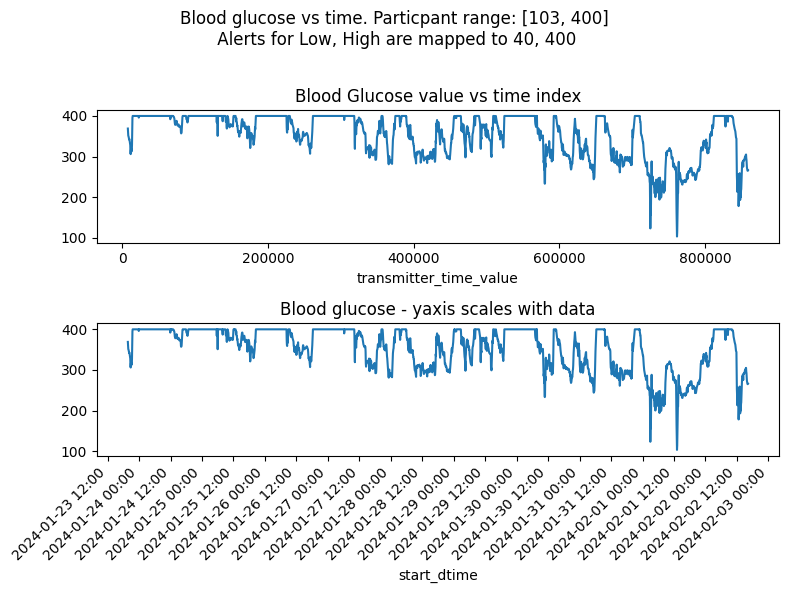

In [952]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f'Blood glucose vs time. Particpant range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')

df.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax[0], legend=False)
ax[0].set_title("Blood Glucose value vs time index")

df.plot.line(x='start_dtime', y='blood_glucose_value', ax=ax[1], legend=False)
ax[1].set_title("Blood Glucose value vs. timestamp")
if (yaxis_adjusts_to_data):
    ax[1].set_title('Blood glucose - yaxis scales with data')
else:
    ax[1].set_title('Blood glucose - yaxis [0, 505]')
    ax[1].set_ylim(0, 505)
ax[1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 12]))  # each day at noon
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=True,       # set ticks along the bottom edge on
#     top=False,         # set ticks along the top edge off
#     labelbottom=True)  # set labels along the bottom edge on

# plt.xlabel('timestamp')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [953]:
#Read the participants manifest
participants_manifest_path = pilot_data_root + 'participants.tsv'
print(participants_manifest_path)

Dataset/dataset/participants.tsv


In [954]:
df_participant = pd.read_csv(participants_manifest_path, sep='\t')
print(df_participant.nunique())  # number of unique participants
df_participant.head()

participant_id               1067
clinical_site                   3
study_group                     4
age                            48
study_visit_date              245
recommended_split               3
cardiac_ecg                     2
clinical_data                   1
environment                     2
retinal_flio                    2
retinal_oct                     2
retinal_octa                    2
retinal_photography             2
wearable_activity_monitor       2
wearable_blood_glucose          2
dtype: int64


,participant_id,clinical_site,study_group,age,study_visit_date,recommended_split,cardiac_ecg,clinical_data,environment,retinal_flio,retinal_oct,retinal_octa,retinal_photography,wearable_activity_monitor,wearable_blood_glucose
0,1001,UW,pre_diabetes_lifestyle_controlled,69,2023-07-27,train,True,True,True,True,True,True,True,False,True
1,1002,UW,healthy,69,2023-08-01,train,True,True,True,True,True,True,True,False,True
2,1003,UW,oral_medication_and_or_non_insulin_injectable_...,82,2023-08-02,train,True,True,True,True,True,True,True,False,True
3,1004,UW,oral_medication_and_or_non_insulin_injectable_...,61,2023-08-08,val,True,True,True,True,True,True,True,False,True
4,1005,UW,insulin_dependent,58,2023-08-08,val,True,True,True,True,True,True,True,False,True


In [955]:
# Calculate mean glucose level for each study group
group_stats = (
    df_participant
    .merge(dfm, on='participant_id')  # Merge on 'participant_id' to combine data
    .groupby('study_group')['average_glucose_level_mg_dl']
    .agg(['mean', 'min', 'max'])
)

age_stats = df_participant['age'].agg(['mean', 'min', 'max'])

# Print the results
print('Group data:')
print(group_stats)
print('-'*50)
print('Age data:')
print(age_stats)

Group data:
                                                          mean         min  \
study_group                                                                  
healthy                                             120.337772   68.589744   
insulin_dependent                                   177.497007  108.544180   
oral_medication_and_or_non_insulin_injectable_m...  150.792876   91.385225   
pre_diabetes_lifestyle_controlled                   128.647238   67.560000   

                                                           max  
study_group                                                     
healthy                                             278.133758  
insulin_dependent                                   300.522583  
oral_medication_and_or_non_insulin_injectable_m...  308.993336  
pre_diabetes_lifestyle_controlled                   290.045364  
--------------------------------------------------
Age data:
mean    60.319588
min     40.000000
max     87.000000
Name: age, dty

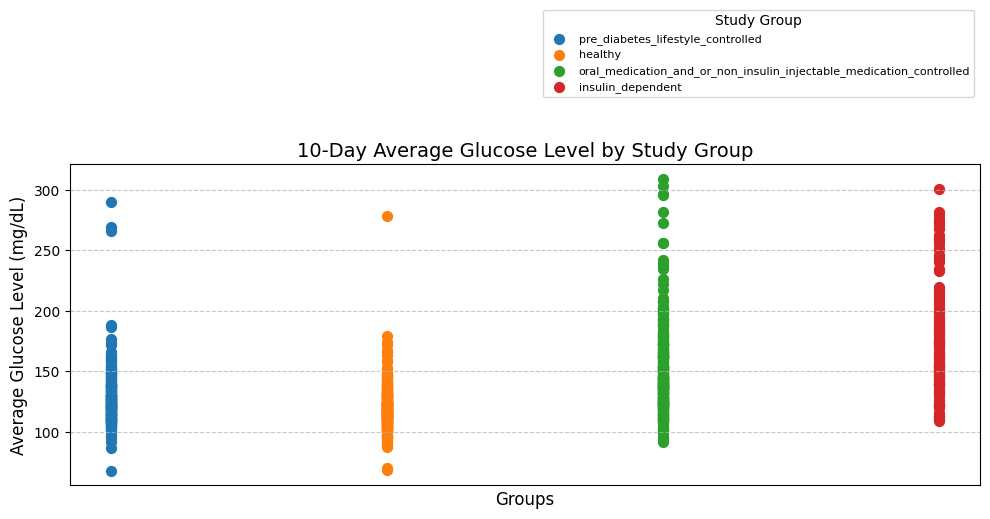

In [956]:
# Merge the participant data with glucose data to include study group information
merged_data = dfm.merge(
    df_participant[['participant_id', 'study_group']],
    on='participant_id'
)

# Scatterplot
plt.figure(figsize=(10, 6))

# Plot for each study group
for group in merged_data['study_group'].unique():
    group_data = merged_data[merged_data['study_group'] == group]
    plt.scatter(
        group_data['study_group'], 
        group_data['average_glucose_level_mg_dl'], 
        label=group, 
        s=50  # Marker size
    )

# Add labels, title, and legend
plt.title('10-Day Average Glucose Level by Study Group', fontsize=14)
plt.xlabel('Groups', fontsize=12)
plt.ylabel('Average Glucose Level (mg/dL)', fontsize=12)
plt.xticks([])
plt.legend(title='Study Group', fontsize=8, bbox_to_anchor=(1, 1.5), loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [957]:
# Set thresholds for high and low glucose levels
high_threshold = 250
low_threshold = 80

# Filter outliers for each group
outliers_by_group = {}
for group in merged_data['study_group'].unique():
    # Get the data for the current group
    group_data = merged_data[merged_data['study_group'] == group]
    
    # Find outliers for the current group
    high_outliers = group_data[group_data['average_glucose_level_mg_dl'] > high_threshold]
    low_outliers = group_data[group_data['average_glucose_level_mg_dl'] < low_threshold]
    
    # Store the results
    outliers_by_group[group] = {
        'high_outliers': high_outliers,
        'low_outliers': low_outliers
    }

# Display outliers for each group
for group, outliers in outliers_by_group.items():
    print(f"\nOutliers for group: {group}")
    print(f"High glucose outliers (above {high_threshold}):")
    print(outliers['high_outliers'][['participant_id', 'average_glucose_level_mg_dl']])
    
    print(f"\nLow glucose outliers (below {low_threshold}):")
    print(outliers['low_outliers'][['participant_id', 'average_glucose_level_mg_dl']])



Outliers for group: pre_diabetes_lifestyle_controlled
High glucose outliers (above 250):
     participant_id  average_glucose_level_mg_dl
151            1154                   269.082485
271            1277                   290.045364
455            4091                   266.253957

Low glucose outliers (below 80):
     participant_id  average_glucose_level_mg_dl
703            7052                        67.56

Outliers for group: healthy
High glucose outliers (above 250):
     participant_id  average_glucose_level_mg_dl
785            7145                   278.133758

Low glucose outliers (below 80):
     participant_id  average_glucose_level_mg_dl
109            1111                    70.000000
669            7008                    68.589744

Outliers for group: oral_medication_and_or_non_insulin_injectable_medication_controlled
High glucose outliers (above 250):
     participant_id  average_glucose_level_mg_dl
26             1027                   281.551471
348            13

In [958]:
df_personal_data = pd.read_csv("personal_data_with_BMI.csv")
df_personal_data.rename(columns={'person_id':'participant_id'}, inplace=True)
print(df_personal_data.head())
df_personal_data.shape

   participant_id  value_as_number_height  value_as_number_weight    BMI
0            1001                   162.0                    57.3  21.83
1            1002                   175.2                    94.1  30.66
2            1003                   160.7                    73.2  28.35
3            1004                   174.5                    76.8  25.22
4            1005                   173.0                    79.6  26.60


(1066, 4)

In [959]:
merged_data = pd.merge(df_personal_data, df_participant)
merged_data.dropna(inplace=True)
print(merged_data.head())
print(merged_data.shape)

   participant_id  value_as_number_height  value_as_number_weight    BMI  \
0            1001                   162.0                    57.3  21.83   
1            1002                   175.2                    94.1  30.66   
2            1003                   160.7                    73.2  28.35   
3            1004                   174.5                    76.8  25.22   
4            1005                   173.0                    79.6  26.60   

  clinical_site                                        study_group  age  \
0            UW                  pre_diabetes_lifestyle_controlled   69   
1            UW                                            healthy   69   
2            UW  oral_medication_and_or_non_insulin_injectable_...   82   
3            UW  oral_medication_and_or_non_insulin_injectable_...   61   
4            UW                                  insulin_dependent   58   

  study_visit_date recommended_split  cardiac_ecg  clinical_data  environment  \
0       202

## Splitting data into age groups and get diabetes percentage

   participant_id  value_as_number_height  value_as_number_weight    BMI  \
0            1001                   162.0                    57.3  21.83   
1            1002                   175.2                    94.1  30.66   
2            1003                   160.7                    73.2  28.35   
3            1004                   174.5                    76.8  25.22   
4            1005                   173.0                    79.6  26.60   

  clinical_site                                        study_group  age  \
0            UW                  pre_diabetes_lifestyle_controlled   69   
1            UW                                            healthy   69   
2            UW  oral_medication_and_or_non_insulin_injectable_...   82   
3            UW  oral_medication_and_or_non_insulin_injectable_...   61   
4            UW                                  insulin_dependent   58   

  study_visit_date recommended_split  cardiac_ecg  clinical_data  environment  \
0       202

C:\Users\Hieu\AppData\Local\Temp\ipykernel_22428\2746733850.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_counts = merged_data.groupby("age_group").size().sort_index()
C:\Users\Hieu\AppData\Local\Temp\ipykernel_22428\2746733850.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_group_counts = merged_data.groupby("bmi_group").size().sort_index()


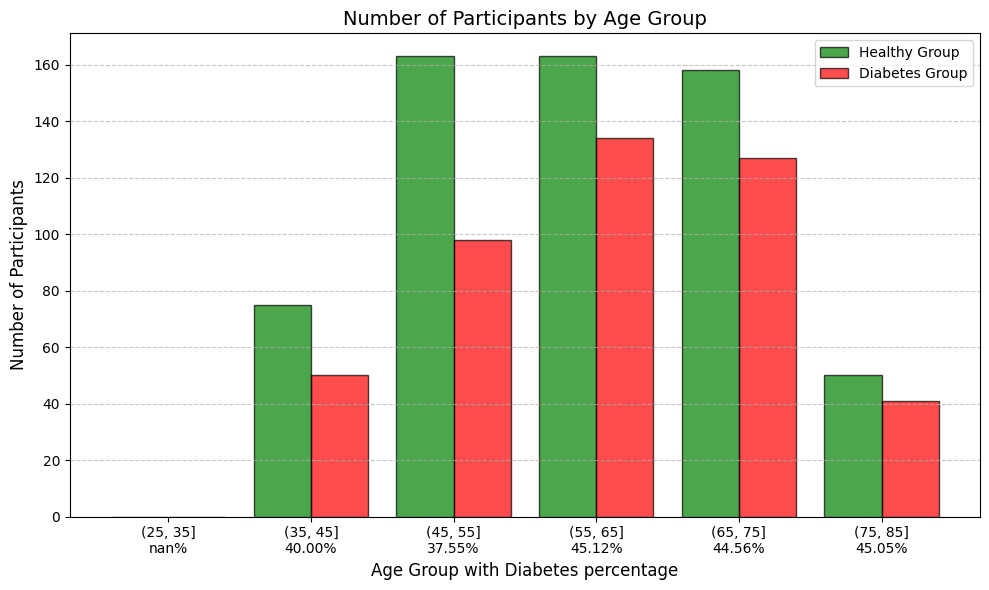

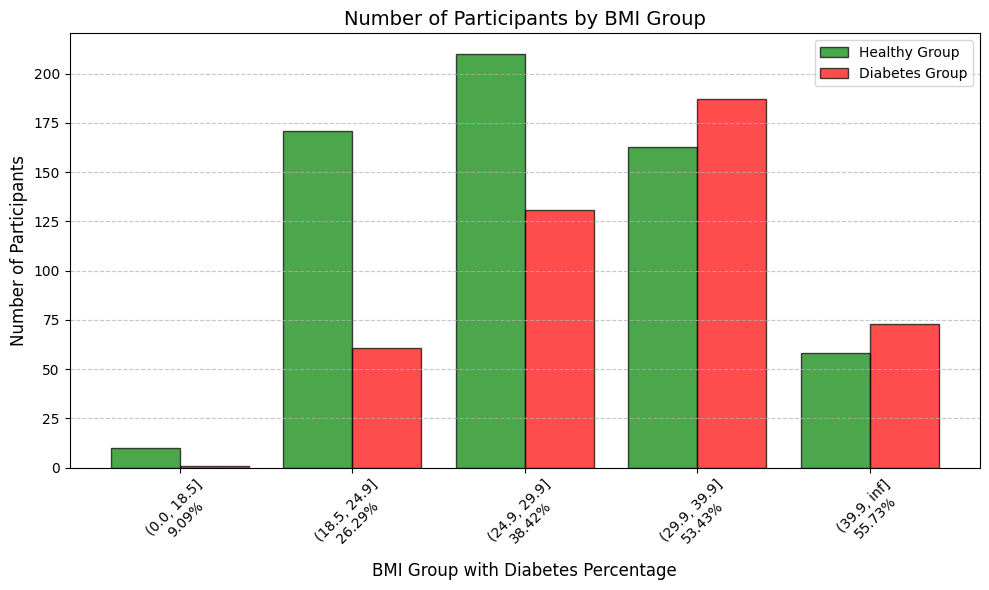

In [960]:

bmi_bins = pd.cut(merged_data["BMI"], bins=[0, 18.5, 24.9, 29.9, 39.9, float("inf")])
age_bins = pd.cut(merged_data["age"], bins=range(25, 95, 10))  # Custom age groups from 25 to 95 increment by 10

# Add bins to the dataframe
merged_data["age_group"] = age_bins
merged_data["bmi_group"] = bmi_bins

print(merged_data.head())

age_group_counts = merged_data.groupby("age_group").size().sort_index()
bmi_group_counts = merged_data.groupby("bmi_group").size().sort_index()

healthy_group = ["healthy", "pre_diabetes_lifestyle_controlled"]
diabetes_group = ["oral_medication_and_or_non_insulin_injectable_medication_controlled", "insulin_dependent"]

print(age_group_counts)
print('-'*50)
print(bmi_group_counts)
print('-'*50)

# Print age count for only participants in the healthy group
healthy_age_counts = merged_data[merged_data['study_group'].isin(healthy_group)]['age_group'].value_counts().sort_index()
diabetes_age_count = merged_data[merged_data['study_group'].isin(diabetes_group)]['age_group'].value_counts().sort_index()

percentage_diabetes = (diabetes_age_count / age_group_counts).sort_index()
print("Diabetes percentage by age: ", percentage_diabetes)

import numpy as np
# Define bar width
bar_width = 0.4  
x = np.arange(len(healthy_age_counts))  # Positions for bars
# Format x labels to include age group and diabetes percentage
x_labels = [f"{age}\n{percent:.2f}%" for age, percent in zip(healthy_age_counts.index.astype(str), percentage_diabetes*100)]


plt.figure(figsize=(10, 6))

# Plot bars side by side
plt.bar(x - bar_width / 2, healthy_age_counts, width=bar_width, color='green', edgecolor='black', label='Healthy Group', alpha=0.7)
plt.bar(x + bar_width / 2, diabetes_age_count, width=bar_width, color='red', edgecolor='black', label='Diabetes Group', alpha=0.7)

# Formatting
plt.title('Number of Participants by Age Group', fontsize=14)
plt.xlabel('Age Group with Diabetes percentage', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.xticks(x, x_labels)  # Ensure x-axis labels are correctly aligned
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

# Count participants in each BMI group for healthy and diabetes groups
healthy_bmi_counts = merged_data[merged_data['study_group'].isin(healthy_group)]['bmi_group'].value_counts().sort_index()
diabetes_bmi_counts = merged_data[merged_data['study_group'].isin(diabetes_group)]['bmi_group'].value_counts().sort_index()

# Calculate the percentage of diabetes patients in each BMI group
percentage_diabetes_bmi = (diabetes_bmi_counts / bmi_group_counts).sort_index()

x = np.arange(len(healthy_bmi_counts))  # Positions for bars

# Format x labels to include BMI group and diabetes percentage
x_labels = [f"{bmi}\n{percent:.2f}%" for bmi, percent in zip(healthy_bmi_counts.index.astype(str), percentage_diabetes_bmi * 100)]

plt.figure(figsize=(10, 6))

# Plot bars side by side
plt.bar(x - bar_width / 2, healthy_bmi_counts, width=bar_width, color='green', edgecolor='black', label='Healthy Group', alpha=0.7)
plt.bar(x + bar_width / 2, diabetes_bmi_counts, width=bar_width, color='red', edgecolor='black', label='Diabetes Group', alpha=0.7)

# Formatting
plt.title('Number of Participants by BMI Group', fontsize=14)
plt.xlabel('BMI Group with Diabetes Percentage', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.xticks(x, x_labels, rotation=45)  # Ensure x-axis labels are correctly aligned and rotated for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


## Boxplot for daily activity count throughout the period


In [961]:
activity_manifest_path = pilot_data_root + "wearable_activity_monitor/manifest.tsv"
df_activity = pd.read_csv(activity_manifest_path, sep='\t')
df_activity.dropna(subset=['physical_activity_filepath'], inplace=True)

print(df_activity.shape)

df_activity_merged = pd.merge(merged_data, df_activity, on='participant_id', how='inner')

df_activity_merged = df_activity_merged[['participant_id', 'study_group', 'age_group', 'bmi_group', 'physical_activity_filepath', 
                           'average_daily_activity']]

print(df_activity_merged.head())

average_daily_activity_by_age_group = df_activity_merged.groupby('age_group')['average_daily_activity'].mean()
print(average_daily_activity_by_age_group)

(905, 27)
   participant_id                                        study_group  \
0            1023                                  insulin_dependent   
1            1024                  pre_diabetes_lifestyle_controlled   
2            1026                  pre_diabetes_lifestyle_controlled   
3            1027  oral_medication_and_or_non_insulin_injectable_...   
4            1028  oral_medication_and_or_non_insulin_injectable_...   

  age_group     bmi_group                         physical_activity_filepath  \
0  (65, 75]  (29.9, 39.9]  /wearable_activity_monitor/physical_activity/g...   
1  (55, 65]  (18.5, 24.9]  /wearable_activity_monitor/physical_activity/g...   
2  (65, 75]  (18.5, 24.9]  /wearable_activity_monitor/physical_activity/g...   
3  (45, 55]  (29.9, 39.9]  /wearable_activity_monitor/physical_activity/g...   
4  (55, 65]  (18.5, 24.9]  /wearable_activity_monitor/physical_activity/g...   

   average_daily_activity  
0                 7797.21  
1                 45

C:\Users\Hieu\AppData\Local\Temp\ipykernel_22428\1944084214.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_daily_activity_by_age_group = df_activity_merged.groupby('age_group')['average_daily_activity'].mean()


C:\Users\Hieu\AppData\Local\Temp\ipykernel_22428\3036685458.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_group', y='average_daily_activity', data=df_activity_merged, palette='Set2')


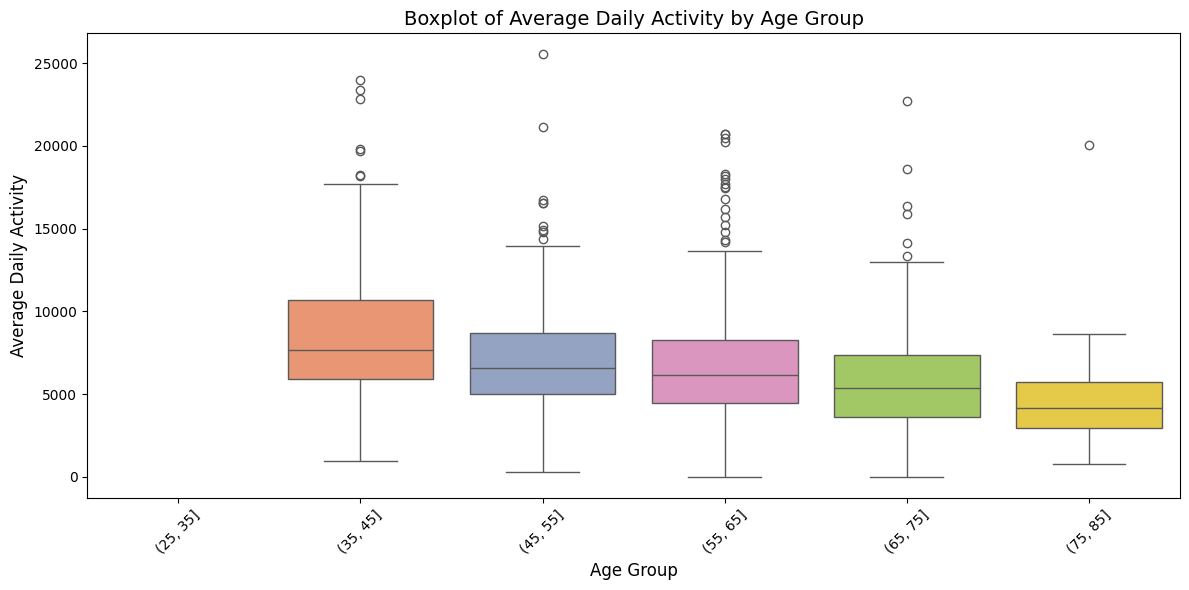

In [962]:
import seaborn as sns

# Plot the boxplot for average daily activity across age groups
plt.figure(figsize=(12, 6))

sns.boxplot(x='age_group', y='average_daily_activity', data=df_activity_merged, palette='Set2')

# Title and labels
plt.title('Boxplot of Average Daily Activity by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Average Daily Activity', fontsize=12)

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\Hieu\AppData\Local\Temp\ipykernel_22428\2100189585.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='study_group', y='average_glucose_level_mg_dl', data=filtered_data, palette={'healthy': 'green', 'diabetes': 'red'})


                                    glucose_filepath  participant_id  \
0  wearable_blood_glucose/continuous_glucose_moni...            1052   
1  wearable_blood_glucose/continuous_glucose_moni...            1063   
2  wearable_blood_glucose/continuous_glucose_moni...            1070   
3  wearable_blood_glucose/continuous_glucose_moni...            1072   
4  wearable_blood_glucose/continuous_glucose_moni...            1077   

   average_glucose_level_mg_dl  glucose_sensor_sampling_duration_days  age  \
0                   144.994398                                     11   61   
1                   167.943322                                      8   57   
2                   168.152661                                     11   57   
3                   137.790266                                     10   61   
4                   121.268190                                     11   64   

     BMI study_group  
0  32.44    diabetes  
1  36.59    diabetes  
2  32.44    diabetes  
3  33.

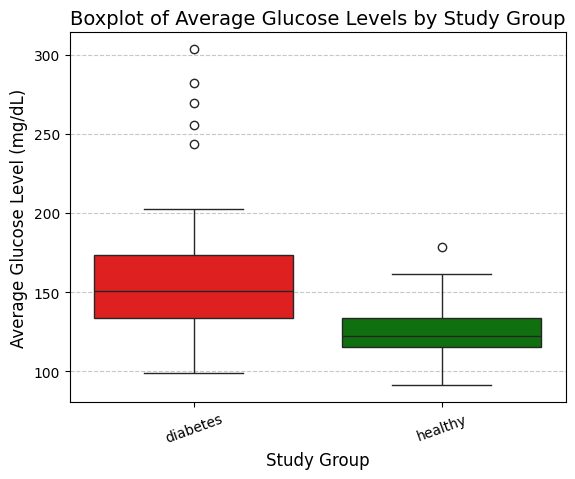

Healthy samples: [1224 4242 7209 7160 7378 1313 7164 4157 7149 4161]
Diabetes samples: [1110 4019 7093 7059 7080 4268 7382 1155 1052 7201]


In [ ]:
# Filter participants by age group (55-65) and same BMI from 29.9 to 39.9
filtered_data = merged_data[(merged_data['age_group'] == pd.Interval(55, 65, closed='right')) & 
              (merged_data['bmi_group'] == pd.Interval(29.9, 39.9, closed='right'))]


# Merge and drop rows where 'glucose_filepath' is missing
filtered_data = (
    filtered_data
    .merge(dfm, on='participant_id', how='inner')  # Keep only matching IDs
    .dropna(subset=['glucose_filepath'])  # Remove rows with missing filepaths
)

# Select relevant columns
filtered_data = filtered_data[['glucose_filepath', 'participant_id', 'average_glucose_level_mg_dl', 
                               'glucose_sensor_sampling_duration_days', 'age', 'BMI', 'study_group']]

# Replace study group names
filtered_data.loc[filtered_data['study_group'].isin(healthy_group), 'study_group'] = 'healthy'
filtered_data.loc[filtered_data['study_group'].isin(diabetes_group), 'study_group'] = 'diabetes'

print(filtered_data.head())

# Create a boxplot for glucose levels by study group
sns.boxplot(x='study_group', y='average_glucose_level_mg_dl', data=filtered_data, palette={'healthy': 'green', 'diabetes': 'red'})

# Title and labels
plt.title('Boxplot of Average Glucose Levels by Study Group', fontsize=14)
plt.xlabel('Study Group', fontsize=12)
plt.ylabel('Average Glucose Level (mg/dL)', fontsize=12)
plt.xticks(rotation=20)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

healthy_samples = filtered_data[filtered_data['study_group'] == 'healthy'].sample(5)  # Randomly select 5 participants where study_group is 'healthy'
diabetes_sample = filtered_data[filtered_data['study_group'] == 'diabetes'].sample(5)  # Randomly select 5 participants where study_group is 'diabetes'

healthy_samples_id = healthy_samples['participant_id'].values
diabetes_samples_id = diabetes_sample['participant_id'].values

print(f"Healthy samples: {healthy_samples_id}")
print(f"Diabetes samples: {diabetes_samples_id}")



In [964]:
def process_cgm_data(sample_id):
  pid = sample_id

  print(f"Looking for participant {pid} in dfm")
  matching_rows = dfm[dfm['participant_id'] == pid]
  print(f"Found rows: {len(matching_rows)}")
  if matching_rows.empty:
    print(f"No matching data for participant {pid}")
    return None  # Return None or handle the case where no data is found

  pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
  cgm_path = pilot_data_root + pid_cgm

  with open(cgm_path,'r') as f:
    data = json.load(f)

  cgm_header = flatten_json(data['header'])

  list_of_body_dicts = list()
  for observation in data['body']['cgm']:
      flat_obs = flatten_json(observation)
      list_of_body_dicts.append(flat_obs)

  df = pd.DataFrame.from_records(list_of_body_dicts)
  df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time', 'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)
  df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

  # df['blood_glucose_value'].value_counts()  # peek at the value distribution
  low_value = 40  # select a value to use for low
  high_value = 400  # select a value to use for high

  if (0):
      df.replace({"Low": low_value, "High": high_value}, inplace=True)  # notebook dev used pd 2.1.4
  else:  # to avoid the FutureWarning regarding Downcasting behavior in 'replace'
      def replace_alt(val, low_value, high_value):
          if val == "Low":
              return low_value
          elif val == "High":
              return high_value
          else:
              return val

      df['blood_glucose_value'] = df.apply(lambda x: replace_alt(x['blood_glucose_value'], low_value, high_value), axis=1)

  return df


Looking for participant 1224 in dfm
Found rows: 1
Looking for participant 4242 in dfm
Found rows: 1
Looking for participant 7209 in dfm
Found rows: 1
Looking for participant 7160 in dfm
Found rows: 1
Looking for participant 7378 in dfm
Found rows: 1
Looking for participant 1313 in dfm
Found rows: 1
Looking for participant 7164 in dfm
Found rows: 1
Looking for participant 4157 in dfm
Found rows: 1
Looking for participant 7149 in dfm
Found rows: 1
Looking for participant 4161 in dfm
Found rows: 1
Looking for participant 1110 in dfm
Found rows: 1
Looking for participant 4019 in dfm
Found rows: 1
Looking for participant 7093 in dfm
Found rows: 1
Looking for participant 7059 in dfm
Found rows: 1
Looking for participant 7080 in dfm
Found rows: 1
Looking for participant 4268 in dfm
Found rows: 1
Looking for participant 7382 in dfm
Found rows: 1
Looking for participant 1155 in dfm
Found rows: 1
Looking for participant 1052 in dfm
Found rows: 1
Looking for participant 7201 in dfm
Found rows: 1


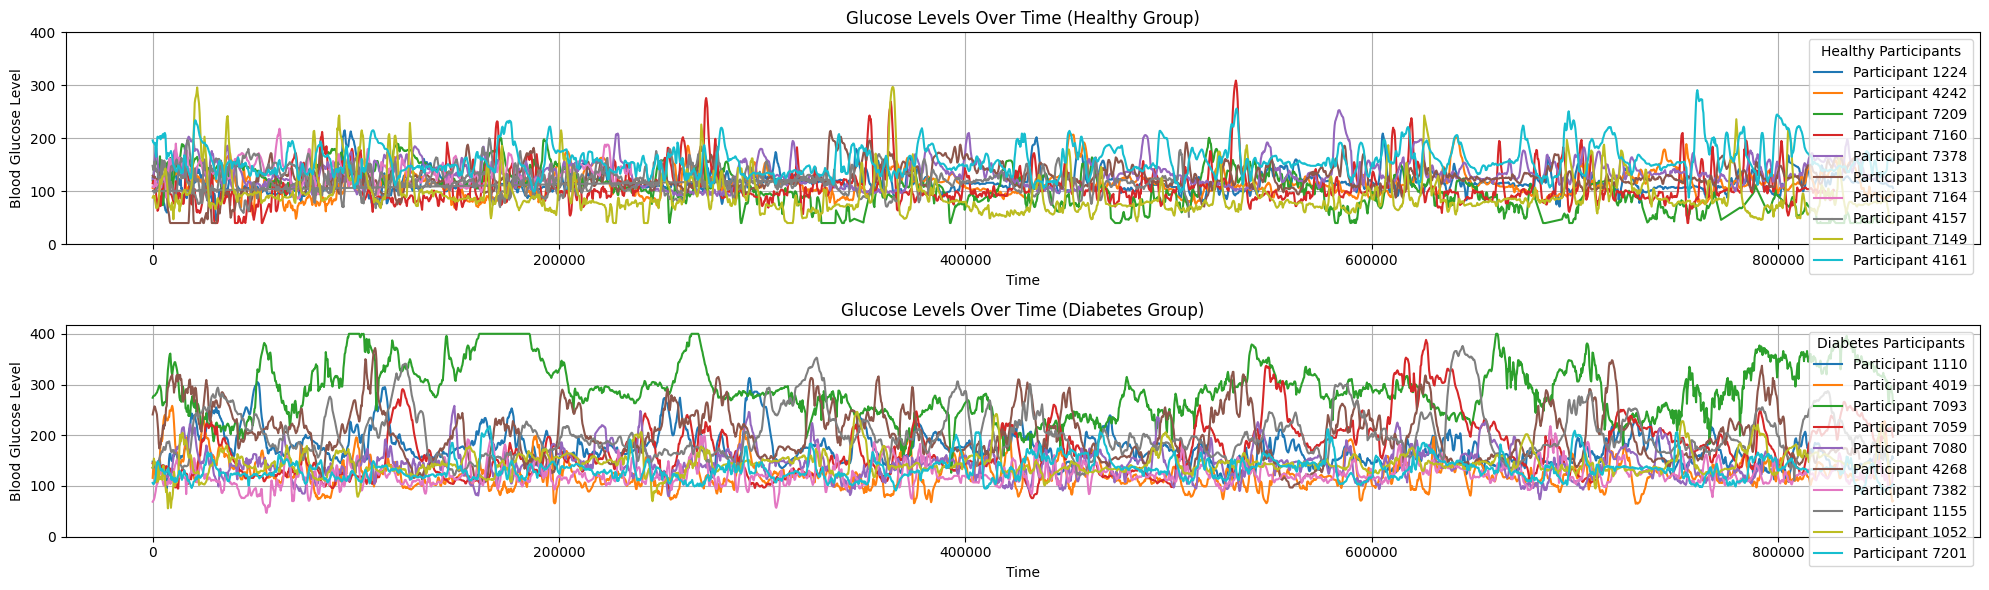

In [965]:
plt.figure(figsize=(20, 6))  # Create a single figure before the loop

yticks = np.arange(0, 401, 100)

# Plot for healthy group (first subplot)
plt.subplot(2, 1, 1)  # (rows, cols, index) - First subplot
for sample_id in healthy_samples_id:
    df = process_cgm_data(sample_id)  # Process data for each patient

    if df is None:
        print(f"Warning: No data found for Participant {sample_id}. Skipping.")
        continue

    # Convert timestamps to relative time (minutes since first entry)
    df['relative_time'] = (df['transmitter_time_value'] - df['transmitter_time_value'].min())
    
    plt.plot(df['relative_time'], df['blood_glucose_value'], label=f'Participant {sample_id}')  # Plot on the same figure

plt.xlabel("Time")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Healthy Participants")
plt.title("Glucose Levels Over Time (Healthy Group)")
plt.yticks(yticks)
plt.grid(True)

# Plot for diabetes group (second subplot)
plt.subplot(2, 1, 2)  # (rows, cols, index) - Second subplot
for sample_id in diabetes_samples_id:  # Select the first 5 samples from the diabetes group
    df = process_cgm_data(sample_id)  # Process data for each patient

    if df is None:
        print(f"Warning: No data found for Participant {sample_id}. Skipping.")
        continue

    # Convert timestamps to relative time (minutes since first entry)
    df['relative_time'] = (df['transmitter_time_value'] - df['transmitter_time_value'].min())
    
    plt.plot(df['relative_time'], df['blood_glucose_value'], label=f'Participant {sample_id}')  # Plot on the same figure

plt.xlabel("Time")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Diabetes Participants")
plt.title("Glucose Levels Over Time (Diabetes Group)")
plt.yticks(yticks)
plt.grid(True)

# Show the combined figure with both subplots
plt.tight_layout()  # Adjust spacing to avoid overlap
plt.show()
      

  
        
  


  

In [966]:
print('Done')

Done
